# Logistic Regression for the Catagerorisation of CMEs

## The Data
The data has been collected from [OMNIWeb](https://omniweb.gsfc.nasa.gov/form/dx1.html) 

- Date: The UTC date for when the CME was detected in Space
- Time: UTC time of detection 
- DST: Disturbance Storm Time measured in nT 
- Disturbance_date: The date when detected on earth
    - This gets encoded into 1 (>100nT) and 0 (<100nT) into the Dst_label column
    - This is the 'Label', 1 or 0
- Disturbance_time: The time when detected on earth

There are then 23 measured parameters for the:
- Magnetic field
    - B(IMF): IMF magnitude average , nT
    - Vector_B: Magnitude, Avg IMF, nT
    - Lat_angle_B: Latitude of average IMF, degrees
    - Long_angle_B: Longitude of average IMF, degrees
    - Bz(GCE): 
    - Bz(GSM): z component of Geocentric Solar Magnetospheric
    - RMS_magnitude: error of magnetic field
    - RMS_field_vector: error of field vector
    - RMS_BZ_GSE: error of z component of GSE field
- Plasma
    - Plasma_Temp: temperature of plasma
    - Proton_Density: the density of protons in the cme
    - Plasma_speed: speed of plasma
    - Alpha/proton: ratio of alpha particles to protons
    - sigma-T 
    - sigma-n
    - sigma-V
    - sigma-ratio
    - flow_pressure: The pressure
    - E_field: electric field
    - Plasma_beta
- Indices
    - Kp_index
    - Ap_index 

## The labels
The labels are based off the DST value of the event. A different DST value will cause different types of geomagnetic storms when the event reaches earth.
- 50 -100 is moderate -> label is 0 (not geoeffective)
- 100- 250 is storm -> label is 1 (geoeffective)
- 250+ is extreme -> for logistic regression the label is 1 aswell, if a mlp is used then it can be labelled 2

## Handling the Data

In [1]:
import pandas as pd 

raw_data = pd.read_csv('dst_events.csv', index_col = 'Date')
data = raw_data.copy()
clean_data = data.dropna()
# encode dst values to 1(DST<-100) and 0(DST>-100)
dst_labels = []
Dates = []
clean_indexes = clean_data.index.tolist()
for i in range(len(clean_data)):
    event = clean_data.iloc[i]
    if(event['DST']<=-100):
        dst_labels.append(1)
        Dates.append(clean_indexes[i])
    elif(event['DST']>-100):
        dst_labels.append(0)
        Dates.append(clean_indexes[i])

clean_data['Dst_label'] = dst_labels
print('number of unique values for dst_label:',clean_data.Dst_label.value_counts())
print('number of rows:',clean_data.shape[0])

number of unique values for dst_label: 0    245
1     65
Name: Dst_label, dtype: int64
number of rows: 310


/tmp/ipykernel_6910/2190121249.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Dst_label'] = dst_labels


## There is a big inbalance in the labels, shorten the 0 labeled data to 65 aswell.

In [2]:
import numpy as np
clean_copy = clean_data.copy()
print('Before sort:\n', clean_copy.Dst_label.value_counts())
clean_copy = clean_copy.sort_values(by='Dst_label')
#print(clean_copy['Dst_label'].to_numpy())
print('after sorting:\n', clean_copy.Dst_label.value_counts())
clean_copy = clean_copy.tail(clean_copy.shape[0]-180)
print('after subsetting:\n', clean_copy.Dst_label.value_counts())

Before sort:
 0    245
1     65
Name: Dst_label, dtype: int64
after sorting:
 0    245
1     65
Name: Dst_label, dtype: int64
after subsetting:
 0    65
1    65
Name: Dst_label, dtype: int64


## Plot data before running logistic regression

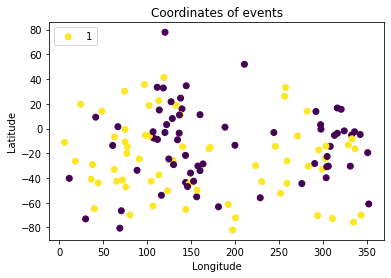

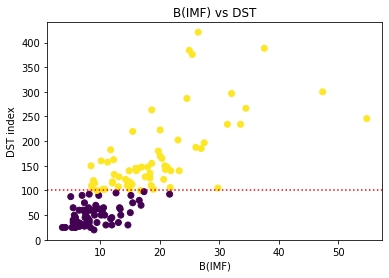

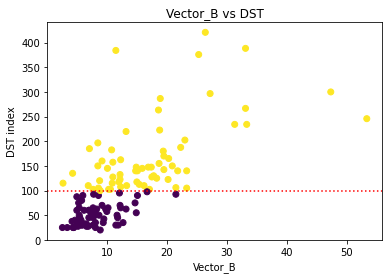

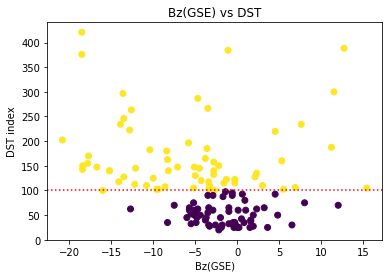

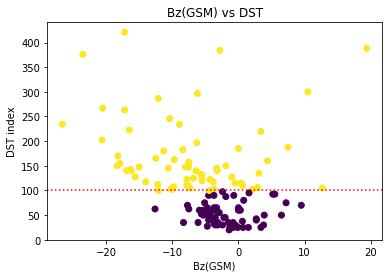

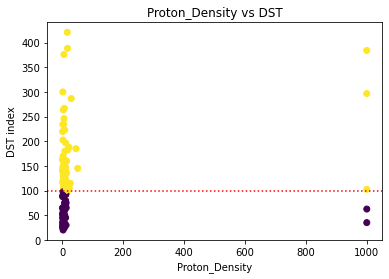

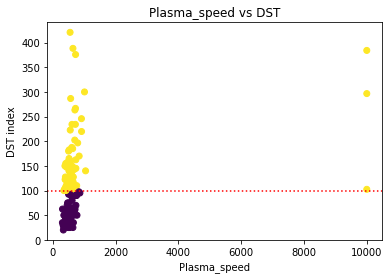

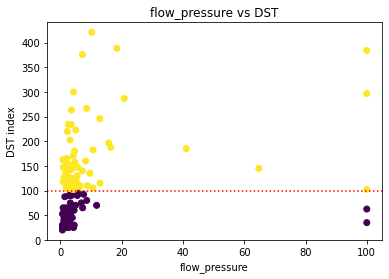

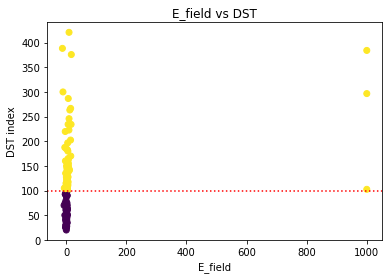

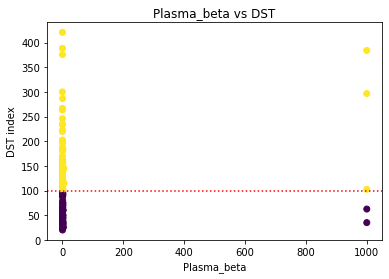

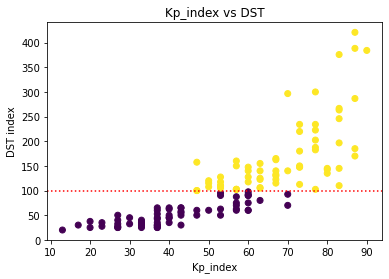

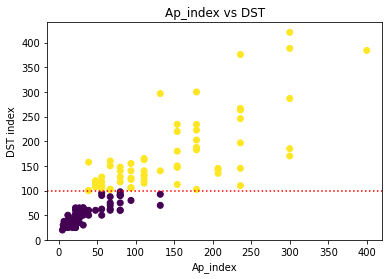

In [6]:
import matplotlib.pyplot as plt
random_order = clean_copy.sample(frac=1)
Y = random_order['Dst_label']
DST = random_order['DST']
params = ['B(IMF)','Vector_B', 'Bz(GSE)', 'Bz(GSM)', 'Proton_Density', 'Plasma_speed', 'flow_pressure', 'E_field', 'Plasma_beta','Kp_index', 'Ap_index']
X = random_order[params]

plt.clf()
plt.title('Coordinates of events')
plt.scatter(x=random_order['Long_angle_B'],y=random_order['Lat_angle_B'] , c=Y, label=Y[0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left')
plt.show()
for param in params:
    plt.clf()
    plt.title(f'{param} vs DST')
    plt.scatter(random_order[param], -DST, c=Y)
    plt.xlabel(param)
    plt.ylabel('DST index')
    plt.axhline(100, 0, 1000, color = 'red', linestyle = 'dotted')
    plt.savefig(f'data_exploration/{param}.png')
    plt.show()

In [ ]:
print(random_order.columns)

## Split and train the data

Trained using logistic regresssion

In [436]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()

Y = random_order['Dst_label']
splits = ['0.8', '0.7', '0.6', '0.5']
lists_of_params = [['Plasma_speed'],
                   ['Bz(GSM)'],
                   ['Long_angle_B', 'Lat_angle_B'],
                   ['Bz(GSM)','Plasma_speed'],
                   ['Lat_angle_B', 'Long_angle_B', 'Bz(GSM)'],
                   ['Lat_angle_B', 'Long_angle_B', 'Plasma_speed'],
                   ['Bz(GSM)', 'Plasma_speed', 'Long_angle_B', 'Lat_angle_B']]

accuracy_scores = [[],[],[],[],[],[],[]]

for split in splits:
    for i, selected_params in enumerate(lists_of_params):
        X = random_order[selected_params]

        X_train = X[:int(130*float(split))]
        Y_train = Y[:int(130*float(split))]
        X_test = X[int(130*float(split)):]
        Y_test = Y[int(130*float(split)):]
        print(len(X_train), len(Y_train), len(X_test), len(Y_test))

        logreg.fit(X_train, Y_train)

        y_pred = logreg.predict(X_test)
        logreg_score = logreg.score(X_test, Y_test)
        accuracy_scores[i].append(logreg_score)

        print('predicted: ',y_pred)
        print('actual:    ',Y_test.to_numpy())
        print(f'{split} split Accuracy of logistic regression classifier on test set using {selected_params}: {logreg_score:.2f}\n \n \n')

print(accuracy_scores)


104 104 26 26
predicted:  [0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0]
actual:     [1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1]
0.8 split Accuracy of logistic regression classifier on test set using ['Plasma_speed']: 0.54
 
 

104 104 26 26
predicted:  [1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1]
actual:     [1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1]
0.8 split Accuracy of logistic regression classifier on test set using ['Bz(GSM)']: 0.81
 
 

104 104 26 26
predicted:  [1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1]
actual:     [1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1]
0.8 split Accuracy of logistic regression classifier on test set using ['Long_angle_B', 'Lat_angle_B']: 0.62
 
 

104 104 26 26
predicted:  [0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1]
actual:     [1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1]
0.8 split Accuracy of logistic regression classifier on test set using ['Bz(GSM)', 'Plasma_speed']: 0.69
 
 


In [333]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)
print(classification_report(Y_test, y_pred))

[[23 11]
 [ 6 25]]
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        34
           1       0.69      0.81      0.75        31

    accuracy                           0.74        65
   macro avg       0.74      0.74      0.74        65
weighted avg       0.75      0.74      0.74        65



## Plotting the results

7
[array([0, 1, 2, 3, 4, 5, 6]), [0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1], [0.2, 1.2000000000000002, 2.2, 3.2, 4.199999999999999, 5.199999999999999, 6.199999999999999], [0.30000000000000004, 1.3000000000000003, 2.3000000000000003, 3.3000000000000003, 4.299999999999999, 5.299999999999999, 6.299999999999999], [0.4, 1.4000000000000004, 2.4000000000000004, 3.4000000000000004, 4.399999999999999, 5.399999999999999, 6.399999999999999], [0.5, 1.5000000000000004, 2.5000000000000004, 3.5000000000000004, 4.499999999999998, 5.499999999999998, 6.499999999999998], [0.6, 1.6000000000000005, 2.6000000000000005, 3.6000000000000005, 4.599999999999998, 5.599999999999998, 6.599999999999998]]
split:  0.8
['Plasma_speed'] accuracy score of 0.54 location: 0
['Bz(GSM)'] accuracy score of 0.81 location: 0.1
['Long_angle_B', 'Lat_angle_B'] accuracy score of 0.62 location: 0.2
['Bz(GSM)', 'Plasma_speed'] accuracy score of 0.69 location: 0.30000000000000004
['Lat_angle_B', 'Long_angle_B', 'Bz(GSM)'] accuracy score of 

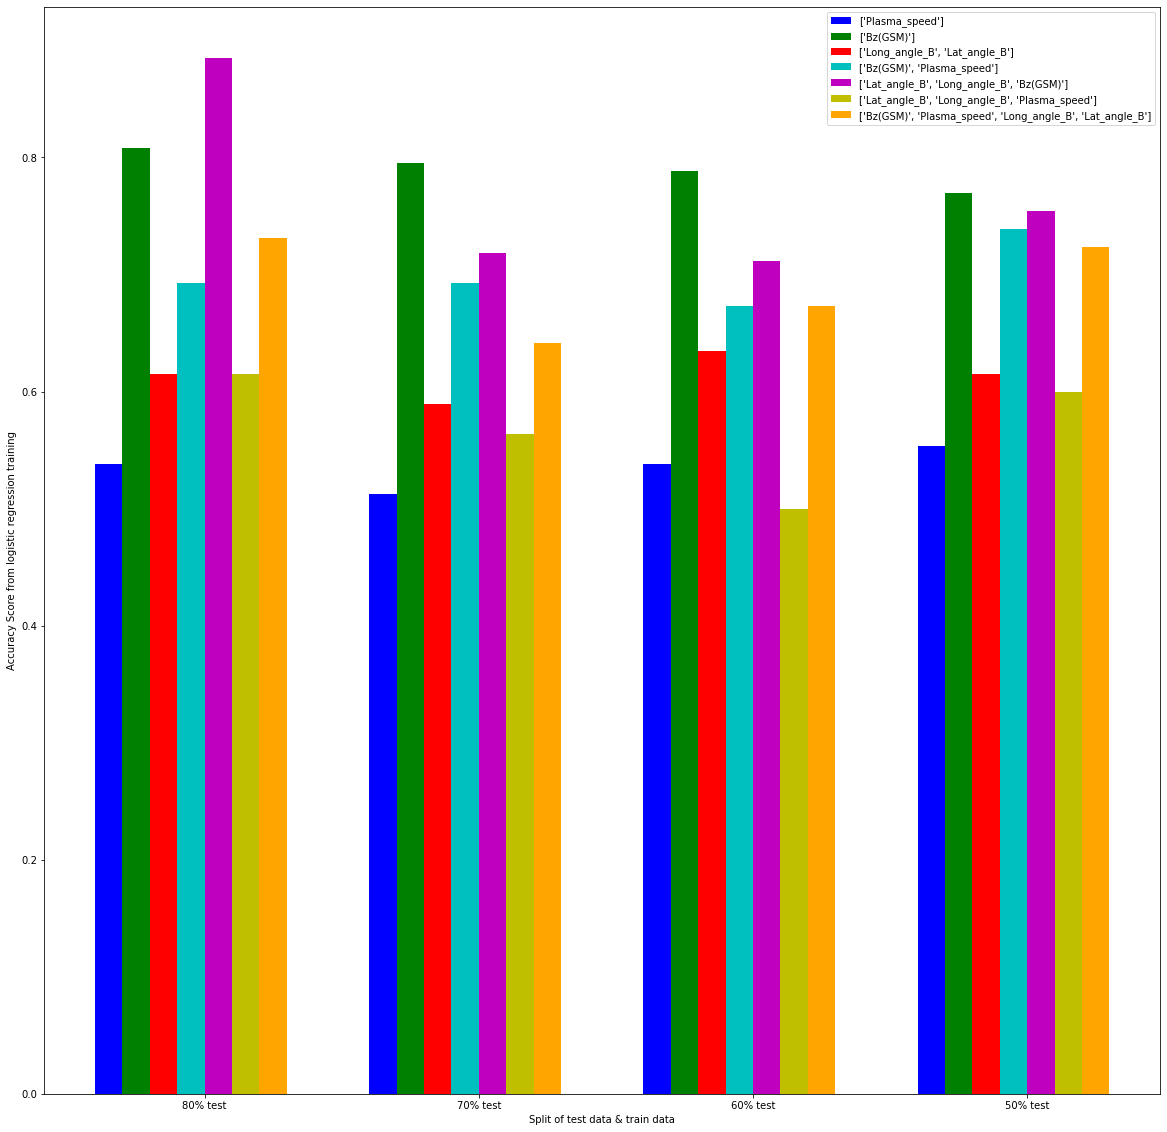

In [518]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(splits))
Barwidth = 1/10

print(len(accuracy_scores))

plas_speed = []
bz = []
long_lat = []
plas_bz = []
long_lat_bz = []
long_lat_plas = []
long_lat_plas_bz = []

fig = plt.subplots(figsize = (20, 20))
br1 = np.arange(len(accuracy_scores))
br2 = [x + Barwidth for x in br1]
br3 = [x + Barwidth for x in br2]
br4 = [x + Barwidth for x in br3]
br5 = [x + Barwidth for x in br4]
br6 = [x + Barwidth for x in br5]
br7 = [x + Barwidth for x in br6]
barlocations = [br1, br2, br3, br4, br5, br6, br7]
print(barlocations)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'orange']
for split in range(len(splits)):
    print('split: ', splits[split])
    
    for i in range(len(lists_of_params)):
        param_score = accuracy_scores[i][split]
        barlocations[i][split]
        print(f'{lists_of_params[i]} accuracy score of {param_score:.2f} location: {barlocations[i][split]}')
        plt.bar(barlocations[i][split],param_score, width = Barwidth, label = lists_of_params[i], color = colours[i])
    print('='*10)
    
split_labels = ['80% test', '70% test', '60% test', '50% test']
plt.xlabel('Split of test data & train data')
plt.ylabel('Accuracy Score from logistic regression training')
plt.xticks([r + Barwidth + 0.25 for r in range(4)], split_labels)
plt.legend(lists_of_params, loc = 'upper right')
#plt.show()
plt.savefig('performance.png')